# MS4S16 Coursework: Deep Learning
### _by `Owhonda Moses`_

## Table of Contents
<ul>
<li><a href="#part1">Part 1</a></li>
<li><a href="#part2">Part 2</a></li>
</ul>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='part1'></a>
# Part 1

Load and read in data

In [2]:
# Set root directory of data
#file_dir = "C:\\Users\\HP\\Documents\\USW\\Courses\\Machine Learning_Deep Learning\\Deep Learning\\MS4S16 - CW_Data"
file_dir = "C:\\Users\\30081432\\Downloads\\Deep Learning\\MS4S16 - CW_Data"

# Import training data
load_train = f'{file_dir}\\train_data.pt'
load_train_labels = f'{file_dir}\\train_labels.pt'

# Import test data
load_test = f'{file_dir}\\test_data.pt'
load_test_labels = f'{file_dir}\\test_labels.pt'

# Load training and testing data
train_images = torch.load(load_train)
test_images = torch.load(load_test)
train_labels = torch.load(load_train_labels)
test_labels = torch.load(load_test_labels)

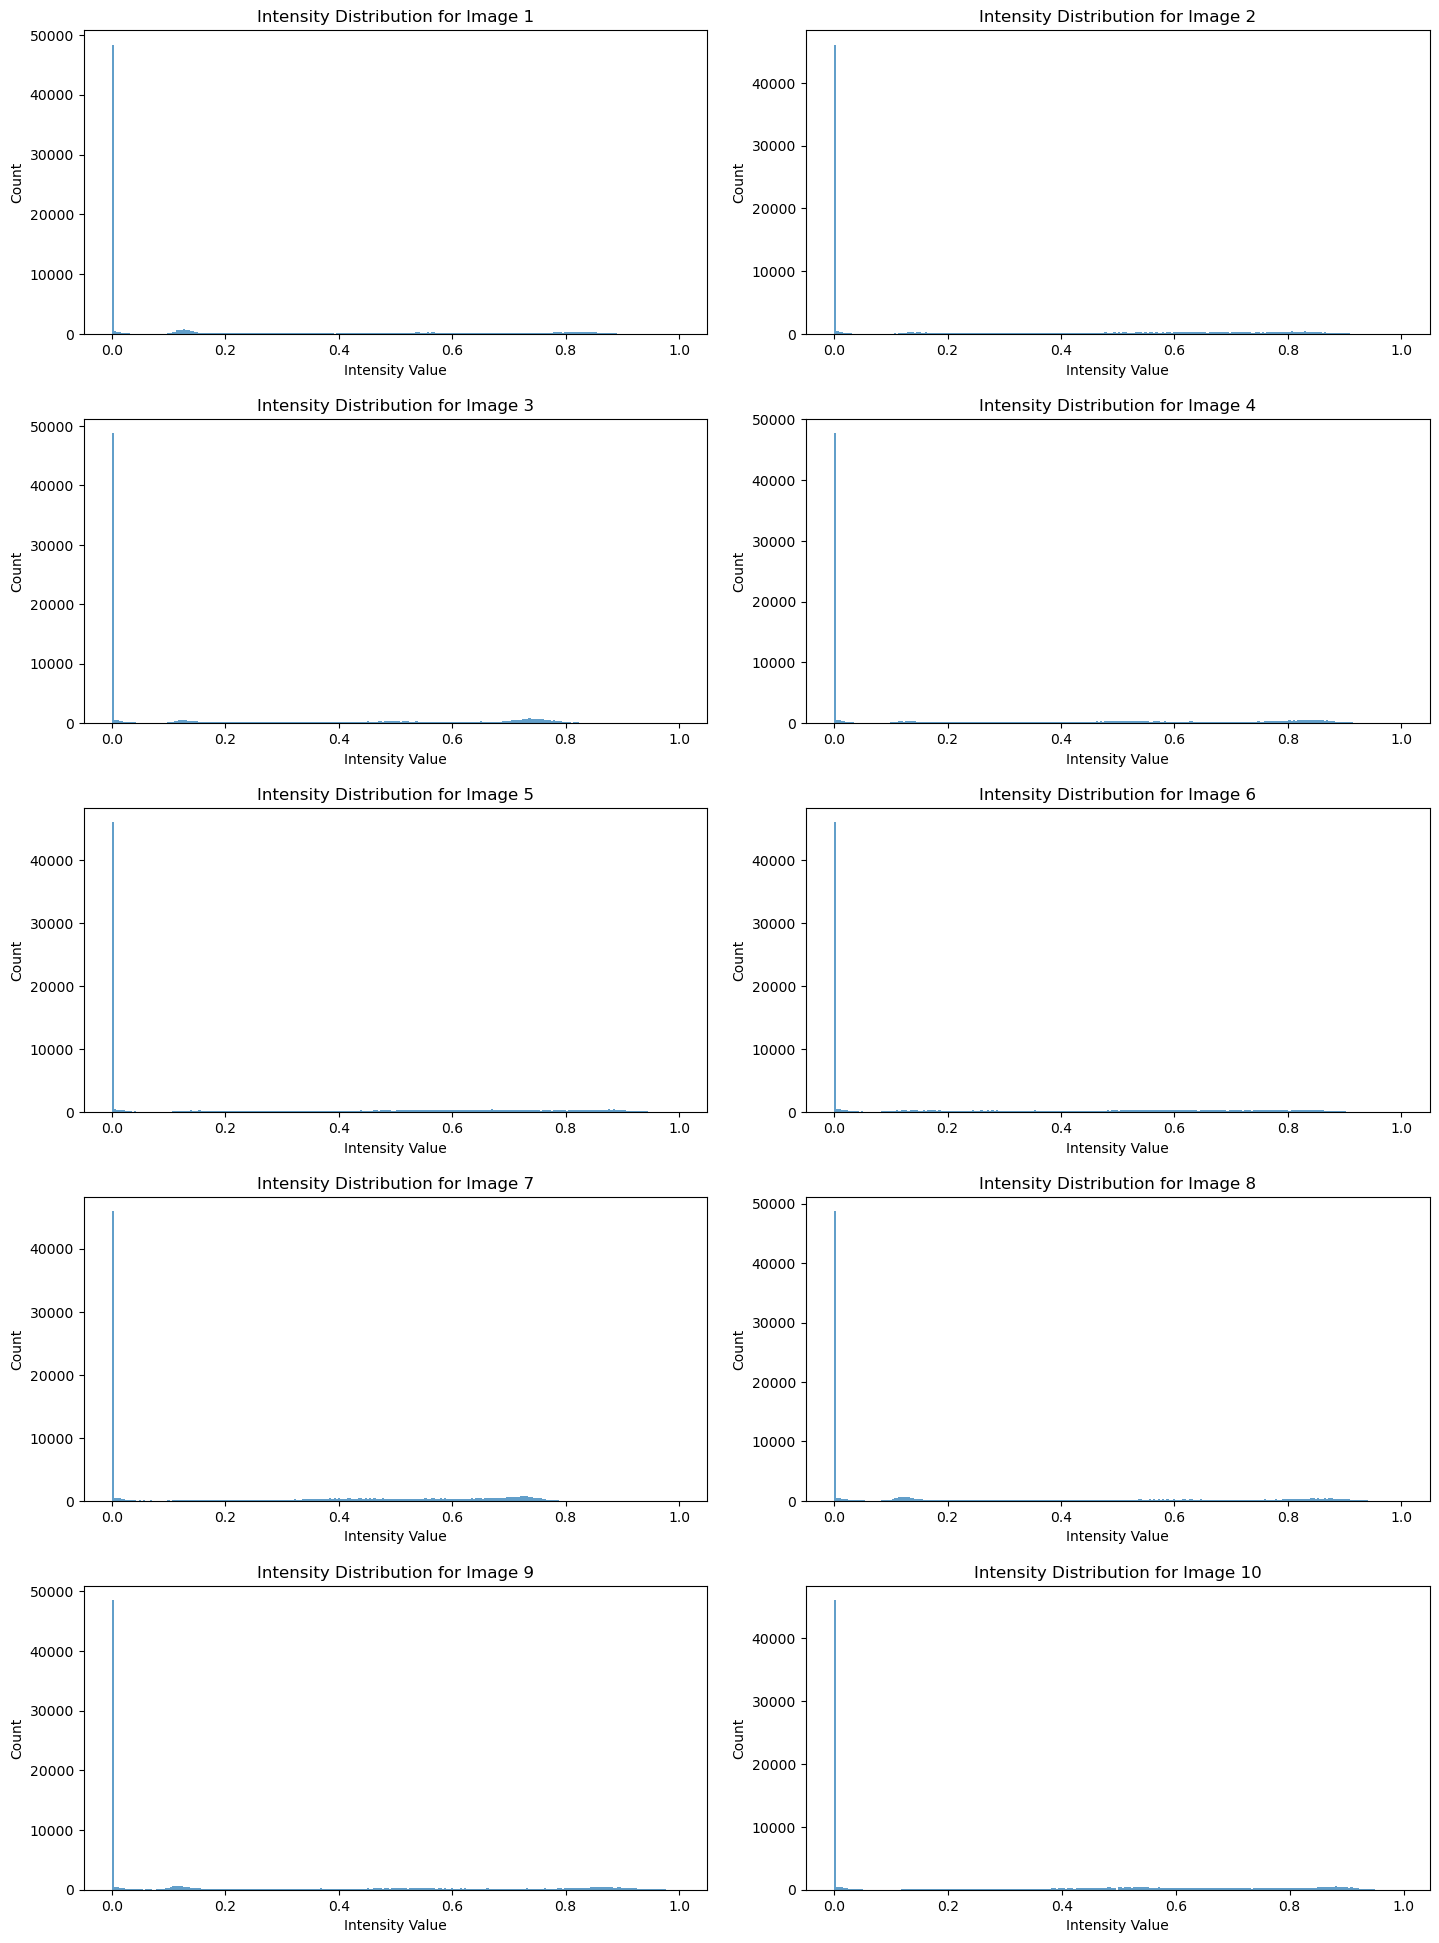

In [3]:
# Plot intensity distribution
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.tight_layout(pad=4.0)
size = 100000

for i, ax in enumerate(axes.flat):
    sampled_pixels = np.random.choice(train_images[i].flatten(), size=size, replace=False)
    ax.hist(sampled_pixels, bins=256, alpha=0.7)
    ax.set_title(f'Intensity Distribution for Image {i+1}')
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Count')

To understand the characteristics of the data, we sampled a subset of pixels from some of the images and plotted the intensity distribution to check for variation in the intensity values across the images. The intensity distribution appears consistent across all images, however, there are varying intensity values, indicating the need for feature scaling.

In [4]:
# Split the training data
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                        test_size=0.2, random_state=42)

# Compute the mean and standard deviation of the training data
mean_val = train_images.mean()
std_val = train_images.std()

# Standardize the data
train_images = (train_images - mean_val) / std_val
val_images = (val_images - mean_val) / std_val
test_images = (test_images - mean_val) / std_val

The same transformation was applied to the validation and test sets to ensure consistency in the data to avoid data leakage and overly optimistic performance estimates.

In [5]:
# Check size of data
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

torch.Size([4096, 3, 208, 176])
torch.Size([1279, 3, 208, 176])
torch.Size([1025, 3, 208, 176])


In [6]:
# Define batch loader function
def batch_loader(batch_size):
    """
    Create DataLoader objects for training, validation, and testing datasets.

    Args:
    - batch_size (int): The number of samples per batch to load.

    Returns:
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - test_loader (DataLoader): DataLoader for the testing dataset.
    """
    # Create Tensor datasets
    train_data = TensorDataset(train_images, train_labels)  
    val_data = TensorDataset(val_images, val_labels)       
    test_data = TensorDataset(test_images, test_labels)     

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)  
    val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)      
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)   

    return train_loader, val_loader, test_loader

In [7]:
 # Initialize batchlaoder with a batch size of 100
train_loader, val_loader, test_loader = batch_loader(100)

In [8]:
# Check number of samples for each batch
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

print(f"Training Dataset: {num_train_batches} batches of {train_loader.batch_size} samples each")
print(f"Testing Dataset: {num_test_batches} batches of {test_loader.batch_size} samples each")

Training Dataset: 41 batches of 100 samples each
Testing Dataset: 13 batches of 100 samples each


In [9]:
# Check dimensions of data
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 3, 208, 176])
torch.Size([100])


Our data appears to have three channels (RGB) suggesting it is colored.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


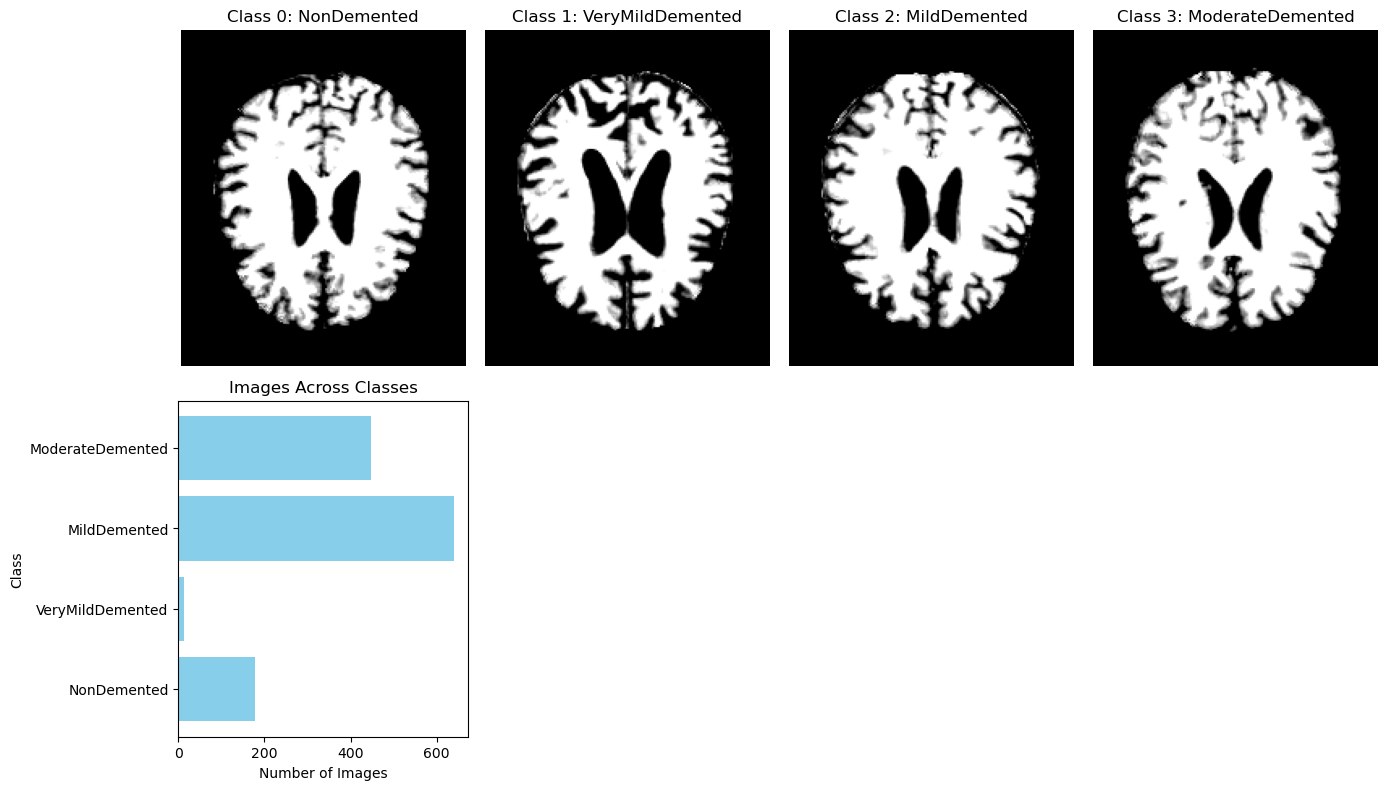

In [10]:
# Define class labels and class names and store in dictionary
class_labels = [0, 1, 2, 3]
classes = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
class_images = {label: [] for label in class_labels}

# Iterate to filter images by class
for images, labels in test_loader:
    for image, label in zip(images, labels):
        if label.item() in class_labels:
            class_images[label.item()].append(image)

# Count the number of images in each class
class_counts = [len(class_images[label]) for label in class_labels]

# Plot visualization
fig, axs = plt.subplots(2, 4, figsize=(14, 8))
for i, label in enumerate(class_labels):
    axs[0, i].imshow(class_images[label][0].permute(1, 2, 0))
    axs[0, i].set_title(f'Class {label}: {classes[label]}')
    axs[0, i].axis('off')

axs[1, 0].barh(classes, class_counts, color='skyblue')
axs[1, 0].set_xlabel('Number of Images')
axs[1, 0].set_ylabel('Class')
axs[1, 0].set_title('Images Across Classes')

for i in range(1, len(class_labels)):
    axs[1, i].axis('off')
    
plt.tight_layout()
plt.show();

The visualization provides an overview of the image distribution across various classes in the dataset, aiding in understanding the data's characteristics and class distribution. However, the visualization suggests that our dataset actually comprises of grayscale images with three channels.

In [11]:
# Flatten images
for images, labels in train_loader:
    images = images.view(images.size(0), -1)
images.shape[1]

109824

Simple neural networks typically expect one-dimensional input. Flattening the images converts them from multi-dimensional arrays (in our case, height x width x channels) into one-dimensional vectors, which can be directly fed into the network.

### Basic Simple Neural Network

Firstly we will build a basic simple neural network, which is a functional neural network that contains just the necessary features to constitute as a simple neural network.

In [12]:
# Define Simple_NN1 class
class Simple_NN1(nn.Module):
    """
    A basic simple neural network model with two fully connected layers.

    Args:
    - input_size (int): Size of the input features.

    Attributes:
    - fc1 (nn.Linear): First fully connected layer.
    - fc2 (nn.Linear): Second fully connected layer.

    Methods:
    - forward(x): Forward pass through the network.

    """
    def __init__(self, input_size):
        """
        Initializes the Simple_NN1 model.

        Args:
        - input_size (int): Size of the input features.
        """
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.fc2 = nn.Linear(2000, 4)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after passing through the network.
        """
        x = x.view(x.size(0), -1)  # Flatten the data
        x = F.relu(self.fc1(x))        
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

In [13]:
# Create an instance of the Simple_NN1 class
torch.manual_seed(3210)
input_size = images.shape[1]
net = Simple_NN1(input_size)

We will set a constant seed value to be able to reproduce our results and for fair comparison with later models.

In [14]:
# Define function to train model
def train(model, train_loader, val_loader, optimizer, epochs, lr):
    """
    Function to train PyTorch model.

    Args:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
    - epochs (int): Number of training epochs.
    - lr (float): Learning rate.

    Returns:
    - None
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"running on {device}...")
    model.to(device)
    
    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer

    # Initialize variables for early stopping
    tolerance = 5
    best_val_loss = float('inf')
    counter = 0
    
    val_acc = []
    train_acc = []
    val_loss_plot = []
    train_loss_plot = []
    
    # Learning rate scheduler for optimizer
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

    # Loop over epochs
    for epoch in range(epochs):
        total_correct = 0
        total_samples = 0
        epoch_loss = 0

        # Training loop
        model.train()
        for batch_data, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device) # Move data to the device

            # Forward pass
            output = model(batch_data)
            loss = loss_function(output, batch_labels)
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

            # Calculate Classification Training Accuracy
            _, predicted = output.max(1)
            total_correct += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

        # Compute training accuracy and loss
        train_accuracy = total_correct / total_samples * 100
        avg_epoch_loss = epoch_loss / len(train_loader) # Calculate loss over the entire training data for each epoch
        train_acc.append(train_accuracy)
        train_loss_plot.append(avg_epoch_loss)

        # Validation loop
        model.eval() 
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            val_total = 0
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.float().to(device), val_labels.to(device)

                val_output = model(val_data)
                val_loss += loss_function(val_output, val_labels).item()

                # Calculate Validation Accuracy
                _, predicted = val_output.max(1)
                val_correct += (predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

            val_accuracy = val_correct / val_total * 100
            avg_val_loss = val_loss / len(val_loader)
            val_acc.append(val_accuracy)
            val_loss_plot.append(avg_val_loss)

            # Print accuracy and loss
            print(f"Training Loss: {avg_epoch_loss:.4f} | Training Accuracy: {train_accuracy:.2f}% | "
                  f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'{model.__class__.__name__}_best_model.pth')
        else:
            counter += 1
            if counter > tolerance:
                print("Early stopping...")
                break
                
        # Step the learning rate scheduler
        scheduler.step()

    # Plot accuracy and loss scores
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    df_accuracy = pd.DataFrame({"Validation Accuracy": val_acc, "Training Accuracy": train_acc})
    sns.lineplot(data=df_accuracy, ax=axs[0])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy Score")
    axs[0].set_xlabel("Number of Epochs")
    axs[0].grid(True)
    
    # Loss subplot
    df_loss = pd.DataFrame({"Validation Loss": val_loss_plot, "Training Loss": train_loss_plot})
    sns.lineplot(data=df_loss, ax=axs[1])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Number of Epochs")
    axs[1].grid(True)
    
    plt.show();

In our training algorithm, we have implemented early stopping to prevent overfitting by stopping the training when the validation scores stop improving.  The learning rate scheduler adjusts the learning rate during the training process based on the number of epochs in order to achieve a better model performance. Our learning rate scheduler has been set to reduce the learning rate by a factor of 0.1 every 10 epochs. 


Setting the tolerance value to 5 means that if the validation loss does not improve for 5 consecutive epochs, the training will be stopped; this is also done to prevent overfitting. The model that achieves the highest validation accuracy and the lowest validation loss during training is saved as the best model which would be used for testing new data.

In [15]:
# Define function to test model
def test(model, test_loader, device, class_names, model_path):
    """
    Function to test a trained PyTorch model.

    Args:
    - model (nn.Module): The trained neural network model to be tested.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - device (torch.device): The device (CPU or GPU) to test the model on.
    - class_names (list): List of class names.
    - model_path (str): File path to the saved model.

    Returns:
    - None
    """
    # Load the best model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)  # Move model to the device

    # Disable gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_scores = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device

            # Perform forward pass
            outputs = model(images)

            # Calculate predicted classes
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

        # Calculate test accuracy
        accuracy = (correct / total)*100
        print(f'Test Accuracy: {accuracy:.2f}%')

        # Convert lists to arrays for metric calculation
        all_predicted = np.array(all_predicted)
        all_labels = np.array(all_labels)
        all_scores = np.array(all_scores)

        # Calculate evaluation metrics for each class
        metrics = {}      
        for i in range(len(class_names)):
            class_predicted = (all_predicted == i)
            class_labels = (all_labels == i)
            accuracy = round(accuracy_score(class_labels, class_predicted), 3)
            precision = round(precision_score(class_labels, class_predicted, zero_division=0), 3)
            recall = round(recall_score(class_labels, class_predicted, zero_division=0), 3)
            metrics[class_names[i]] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}

            # Calculate Precision-Recall curve and AUPRC
            precision, recall, _ = precision_recall_curve(class_labels, all_scores[:, i])
            auprc = round(auc(recall, precision), 3)
            metrics[class_names[i]]['AUPRC'] = auprc

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predicted, labels=range(len(class_names)))

        # Plot Precision-Recall curve and confusion matrix
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))        
        for i in range(len(class_names)):
            precision, recall, _ = precision_recall_curve((all_labels == i), all_scores[:, i])
            auprc = auc(recall, precision)
            axs[0].plot(recall, precision, label=f'{class_names[i]} (AUPRC = {auprc:.2f})')

        axs[0].set_xlabel('Recall')
        axs[0].set_ylabel('Precision')
        axs[0].set_title('Precision-Recall Curve')
        axs[0].legend()

        ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot(ax=axs[1], xticks_rotation=40, cmap='cividis')
        axs[1].set_title('Confusion Matrix')

        plt.tight_layout()
        plt.show();

        for class_name, metric in metrics.items():
            print(f'{class_name}: {metric}')

running on cuda...


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 10.97it/s]


Training Loss: 1.0020 | Training Accuracy: 51.66% | Validation Loss: 0.9467 | Validation Accuracy: 56.20%


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.14it/s]


Training Loss: 0.9231 | Training Accuracy: 55.08% | Validation Loss: 0.9462 | Validation Accuracy: 53.66%


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.19it/s]


Training Loss: 0.8981 | Training Accuracy: 56.98% | Validation Loss: 0.9146 | Validation Accuracy: 56.88%


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.15it/s]


Training Loss: 0.8670 | Training Accuracy: 59.06% | Validation Loss: 0.8498 | Validation Accuracy: 62.93%


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.06it/s]


Training Loss: 0.8367 | Training Accuracy: 61.11% | Validation Loss: 0.8830 | Validation Accuracy: 57.95%


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.61it/s]


Training Loss: 0.8032 | Training Accuracy: 62.96% | Validation Loss: 0.8054 | Validation Accuracy: 63.61%


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 18.98it/s]


Training Loss: 0.8022 | Training Accuracy: 62.40% | Validation Loss: 0.8485 | Validation Accuracy: 59.71%


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.66it/s]


Training Loss: 0.7725 | Training Accuracy: 64.16% | Validation Loss: 0.8143 | Validation Accuracy: 61.85%


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.65it/s]


Training Loss: 0.7557 | Training Accuracy: 66.09% | Validation Loss: 0.7583 | Validation Accuracy: 69.27%


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.04it/s]


Training Loss: 0.7360 | Training Accuracy: 67.31% | Validation Loss: 0.7625 | Validation Accuracy: 64.68%


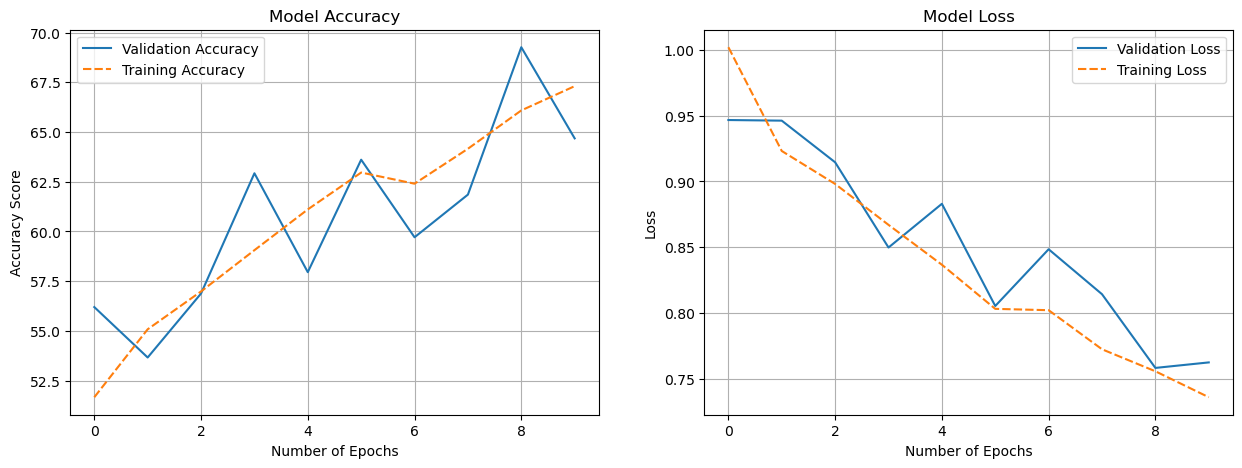

Test Accuracy: 54.57%


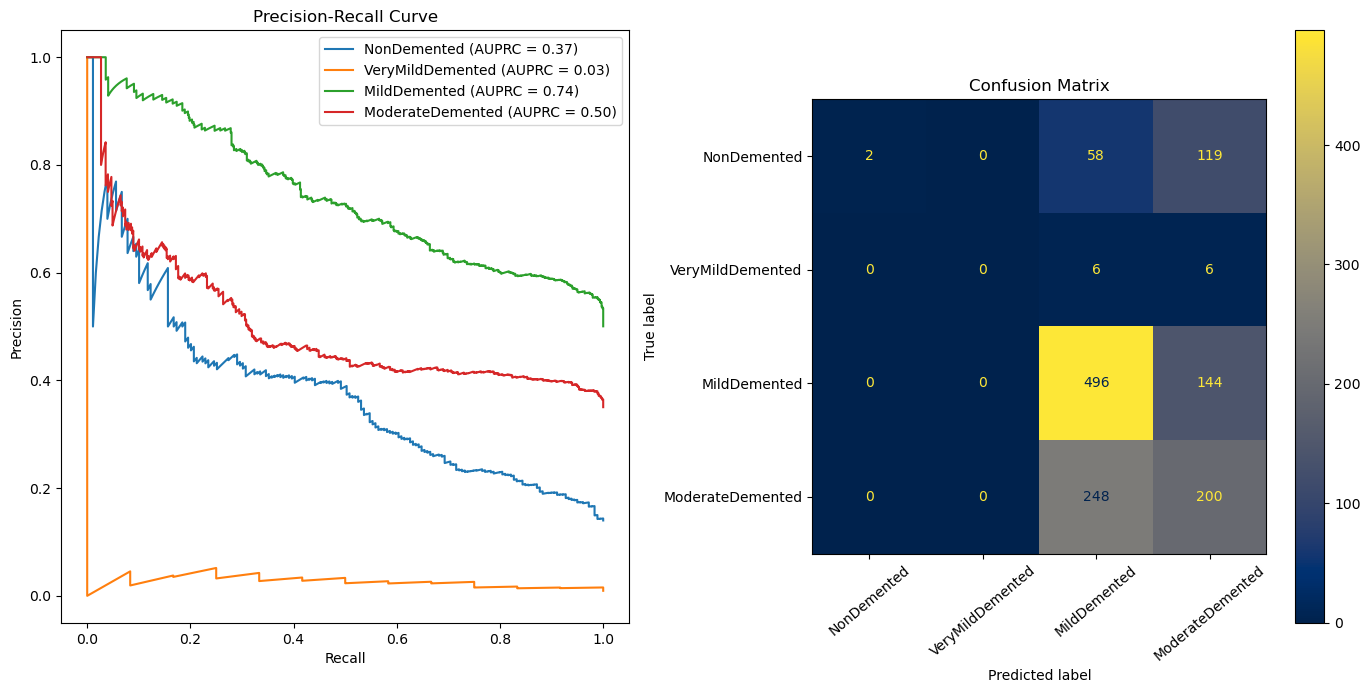

NonDemented: {'Accuracy': 0.862, 'Precision': 1.0, 'Recall': 0.011, 'AUPRC': 0.374}
VeryMildDemented: {'Accuracy': 0.991, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.026}
MildDemented: {'Accuracy': 0.643, 'Precision': 0.614, 'Recall': 0.775, 'AUPRC': 0.741}
ModerateDemented: {'Accuracy': 0.596, 'Precision': 0.426, 'Recall': 0.446, 'AUPRC': 0.497}


In [16]:
# Initialize basic simple neural network
lr=0.01
class_names = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
optimizer = optim.SGD(net.parameters(), lr=lr)
model_path = f'{file_dir}\\{net.__class__.__name__}_best_model.pth'

# Train and test model
train(net, train_loader, val_loader, optimizer, epochs=10, lr=lr)
test(net, test_loader, torch.device('cpu'), class_names, model_path)

### Basic Convolutional Neural Network

In order to understand the shape of our data, we will run a test sample of data through our model before training.

In [17]:
# Define the initial Conv_NN1 class
class Conv_NN1(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = n_channels, out_channels = 16, kernel_size = (5,5) )
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32,  kernel_size = (5,5))
        self.pool = nn.MaxPool2d((2,2))
   
    def forward(self, x):       
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        print(f"Shape of Data before Flattening: {x.shape}")

        return x

In [18]:
# Create an instance of the CONV_NN1 class and run test sample
net = Conv_NN1(n_channels = 3)

# Run test sample
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    outputs = net(inputs)
    dim = nn.Flatten(1) # Flatten to one dimension
    outputs_ = dim(outputs)
    print(f"The Shape of the data is: {outputs_.shape}")
    break

Shape of Data before Flattening: torch.Size([100, 32, 49, 41])
The Shape of the data is: torch.Size([100, 64288])


In [19]:
# Update the Conv_NN1 class
class Conv_NN1(nn.Module):
    """
    A basic convolutional neural network model with two convolutional layers and two fully connected layers.

    Args:
    - n_channels (int): Number of input channels.

    Attributes:
    - conv1 (nn.Conv2d): First convolutional layer.
    - conv2 (nn.Conv2d): Second convolutional layer.
    - pool (nn.MaxPool2d): Max pooling layer.
    - flatten (nn.Flatten): Flatten layer to convert 2D image maps into 1D.
    - fc1 (nn.Linear): First fully connected layer.
    - fc2 (nn.Linear): Second fully connected layer.

    Methods:
    - forward(x): Forward pass through the network.

    """

    def __init__(self, n_channels):
        """
        Initializes the Conv_NN2 model.

        Args:
        - n_channels (int): Number of input channels.
        """
        super().__init__()
        
        # Define convolutional layers and max pooling layer
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d((2, 2))
         
        # Flatten data
        self.flatten = nn.Flatten()
        
        # Define linear layers
        self.fc1 = nn.Linear(64288, 5000)
        self.fc2 = nn.Linear(5000, 4)
        
    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after passing through the network.
        """
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten data & linear layers        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)

        return x

In [20]:
# Create an instance of the CONV_NN1 class
torch.manual_seed(3210)
net = Conv_NN1(n_channels = 3)

running on cuda...


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  6.91it/s]


Training Loss: 1.0551 | Training Accuracy: 49.83% | Validation Loss: 0.9859 | Validation Accuracy: 51.41%


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.40it/s]


Training Loss: 0.9692 | Training Accuracy: 53.32% | Validation Loss: 0.9588 | Validation Accuracy: 56.49%


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.29it/s]


Training Loss: 0.9296 | Training Accuracy: 55.59% | Validation Loss: 0.9038 | Validation Accuracy: 54.63%


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.43it/s]


Training Loss: 0.9076 | Training Accuracy: 56.62% | Validation Loss: 0.9278 | Validation Accuracy: 56.88%


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.44it/s]


Training Loss: 0.8963 | Training Accuracy: 57.15% | Validation Loss: 0.9058 | Validation Accuracy: 57.95%


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.43it/s]


Training Loss: 0.8778 | Training Accuracy: 58.59% | Validation Loss: 0.8602 | Validation Accuracy: 58.93%


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.35it/s]


Training Loss: 0.8613 | Training Accuracy: 59.99% | Validation Loss: 0.8730 | Validation Accuracy: 60.78%


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.46it/s]


Training Loss: 0.8538 | Training Accuracy: 60.89% | Validation Loss: 0.8486 | Validation Accuracy: 60.59%


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.26it/s]


Training Loss: 0.8484 | Training Accuracy: 60.50% | Validation Loss: 0.8465 | Validation Accuracy: 60.88%


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  8.41it/s]


Training Loss: 0.8355 | Training Accuracy: 61.79% | Validation Loss: 0.8437 | Validation Accuracy: 61.17%


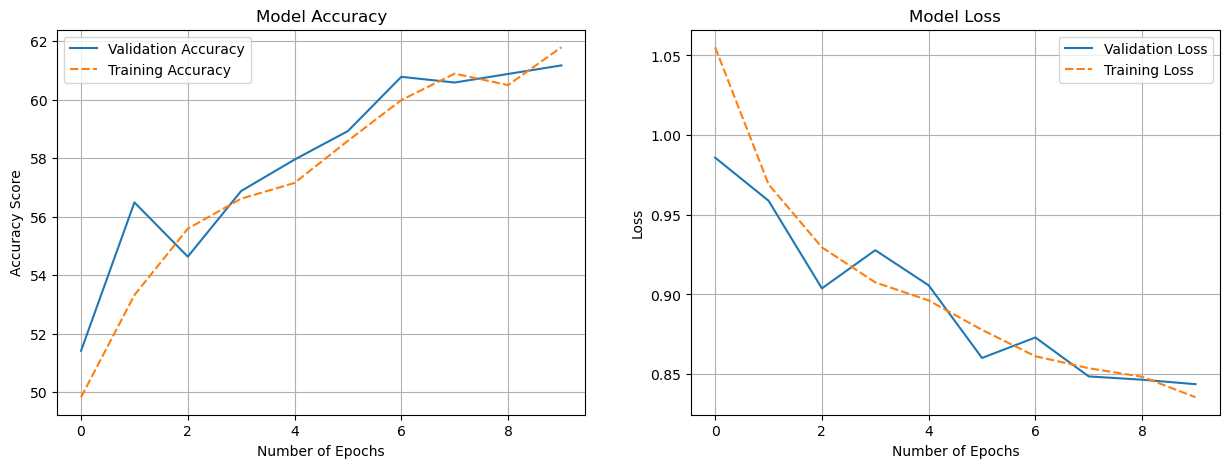

Test Accuracy: 54.34%


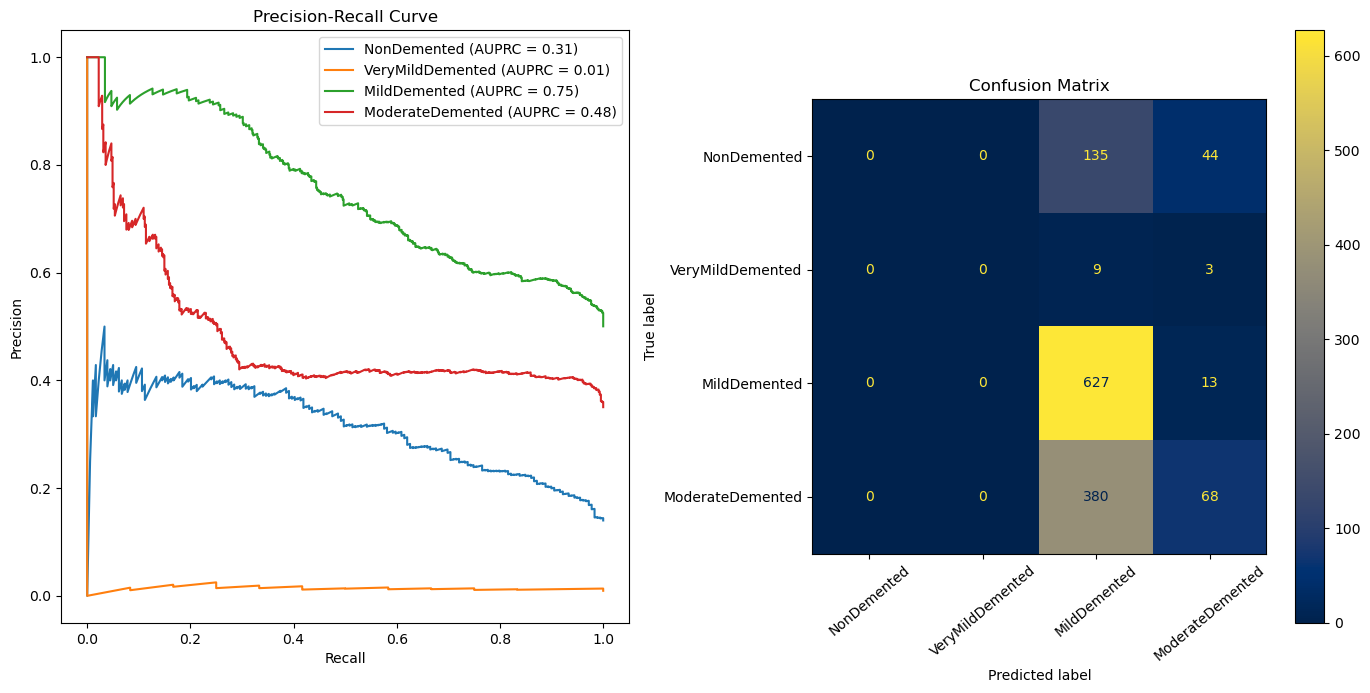

NonDemented: {'Accuracy': 0.86, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.313}
VeryMildDemented: {'Accuracy': 0.991, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.014}
MildDemented: {'Accuracy': 0.58, 'Precision': 0.545, 'Recall': 0.98, 'AUPRC': 0.75}
ModerateDemented: {'Accuracy': 0.656, 'Precision': 0.531, 'Recall': 0.152, 'AUPRC': 0.48}


In [21]:
# Initialize basic CNN
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
model_path = f'{file_dir}\\{net.__class__.__name__}_best_model.pth'

# Train and test model
train(net, train_loader, val_loader, optimizer, epochs=10, lr=lr)
test(net, test_loader, torch.device('cpu'), class_names, model_path)

The accuracy plot shows how well the model is predicting the correct labels, and the loss plot shows how well the model is minimizing the error between the predicted and actual labels. The goal is to maximize the accuracy and minimize the loss. The confusion matrix breaks down the classification performance for each class, while the precision-recall curve provides insights into the model's ability to balance precision and recall.

From the results of the basic models, we can observe that the training accuracy increases over epochs, however the validation accuracy and losses have significant fluctuations, which potentially indicate overfitting to unseen or validation data. Similarly, the AUPRC in the precision-recall curve indicates that the models do not exhibit a good trade-off between precision and recall across different thresholds.
We will now build improved neural networks with changes to the model architectures and training algorithm to improve the results.

### Improved Simple Neural Network

In [22]:
# Define Simple_NN2 class for improved simple neural network
class Simple_NN2(nn.Module):
    """
    An improved simple neural network model with multiple fully connected layers and dropout regularization.

    Args:
    - input_size (int): Size of the input features.

    Attributes:
    - fc1 (nn.Linear): First fully connected layer.
    - fc2 (nn.Linear): Second fully connected layer.
    - fc3 (nn.Linear): Third fully connected layer.
    - fc4 (nn.Linear): Fourth fully connected layer.
    - fc5 (nn.Linear): Fifth fully connected layer.
    - fc6 (nn.Linear): Final fully connected layer for output.
    - dropout (nn.Dropout): Dropout layer for regularization.

    Methods:
    - forward(x): Forward pass through the network.

    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)   
        self.fc4 = nn.Linear(512, 256)   
        self.fc5 = nn.Linear(256, 128) 
        self.fc6 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.3)      

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after passing through the network.
        """
        x = x.view(x.size(0), -1)  # Flatten the data
        x = F.relu(self.fc1(x))             
        x = self.dropout(x)                 
        x = F.relu(self.fc2(x))             
        #x = self.dropout(x)                 
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)  
        x = F.relu(self.fc4(x))             
        #x = self.dropout(x)                 
        x = F.relu(self.fc5(x))             
        x = self.dropout(x)                               
        x = F.log_softmax(self.fc6(x), dim = 1)                     
        
        return x

In [23]:
# Create an instance of the improved simple neural network
torch.manual_seed(3210)
input_size = images.shape[1]
net = Simple_NN2(input_size)

running on cuda...


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.07it/s]


Training Loss: 1.0345 | Training Accuracy: 50.20% | Validation Loss: 0.8997 | Validation Accuracy: 52.68%


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.18it/s]


Training Loss: 0.9396 | Training Accuracy: 53.78% | Validation Loss: 0.8678 | Validation Accuracy: 57.37%


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.19it/s]


Training Loss: 0.8879 | Training Accuracy: 57.30% | Validation Loss: 0.8181 | Validation Accuracy: 58.63%


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.18it/s]


Training Loss: 0.8263 | Training Accuracy: 60.67% | Validation Loss: 0.8038 | Validation Accuracy: 63.71%


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.17it/s]


Training Loss: 0.8237 | Training Accuracy: 60.60% | Validation Loss: 0.9439 | Validation Accuracy: 55.12%


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.26it/s]


Training Loss: 0.7568 | Training Accuracy: 64.94% | Validation Loss: 0.7215 | Validation Accuracy: 65.66%


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.19it/s]


Training Loss: 0.7262 | Training Accuracy: 66.85% | Validation Loss: 0.6631 | Validation Accuracy: 69.76%


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.19it/s]


Training Loss: 0.7040 | Training Accuracy: 69.17% | Validation Loss: 0.6316 | Validation Accuracy: 70.63%


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.19it/s]


Training Loss: 0.6388 | Training Accuracy: 72.66% | Validation Loss: 0.7988 | Validation Accuracy: 66.05%


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.20it/s]


Training Loss: 0.5899 | Training Accuracy: 74.76% | Validation Loss: 0.5185 | Validation Accuracy: 77.76%


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.18it/s]


Training Loss: 0.3815 | Training Accuracy: 86.16% | Validation Loss: 0.4024 | Validation Accuracy: 83.51%


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.19it/s]


Training Loss: 0.3354 | Training Accuracy: 87.18% | Validation Loss: 0.4640 | Validation Accuracy: 82.34%


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.25it/s]


Training Loss: 0.3095 | Training Accuracy: 88.79% | Validation Loss: 0.3773 | Validation Accuracy: 84.88%


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.19it/s]


Training Loss: 0.2806 | Training Accuracy: 89.62% | Validation Loss: 0.3969 | Validation Accuracy: 84.10%


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.20it/s]


Training Loss: 0.2744 | Training Accuracy: 89.89% | Validation Loss: 0.3652 | Validation Accuracy: 86.15%


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 11.87it/s]


Training Loss: 0.2624 | Training Accuracy: 90.60% | Validation Loss: 0.3521 | Validation Accuracy: 86.15%


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.08it/s]


Training Loss: 0.2407 | Training Accuracy: 90.97% | Validation Loss: 0.3396 | Validation Accuracy: 86.63%


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.03it/s]


Training Loss: 0.2314 | Training Accuracy: 91.53% | Validation Loss: 0.4521 | Validation Accuracy: 86.73%


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 11.98it/s]


Training Loss: 0.2180 | Training Accuracy: 91.67% | Validation Loss: 0.3035 | Validation Accuracy: 88.00%


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.03it/s]


Training Loss: 0.2080 | Training Accuracy: 92.53% | Validation Loss: 0.3130 | Validation Accuracy: 87.51%


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.20it/s]


Training Loss: 0.1916 | Training Accuracy: 93.02% | Validation Loss: 0.2987 | Validation Accuracy: 87.90%


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.10it/s]


Training Loss: 0.1864 | Training Accuracy: 93.12% | Validation Loss: 0.3426 | Validation Accuracy: 87.61%


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.05it/s]


Training Loss: 0.1817 | Training Accuracy: 93.55% | Validation Loss: 0.3032 | Validation Accuracy: 88.88%


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 11.65it/s]


Training Loss: 0.1796 | Training Accuracy: 93.63% | Validation Loss: 0.3170 | Validation Accuracy: 88.20%


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 11.69it/s]


Training Loss: 0.1810 | Training Accuracy: 93.38% | Validation Loss: 0.2932 | Validation Accuracy: 88.39%


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.08it/s]


Training Loss: 0.1759 | Training Accuracy: 93.55% | Validation Loss: 0.2959 | Validation Accuracy: 88.29%


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 11.95it/s]


Training Loss: 0.1805 | Training Accuracy: 93.70% | Validation Loss: 0.2876 | Validation Accuracy: 88.68%


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.13it/s]


Training Loss: 0.1727 | Training Accuracy: 93.99% | Validation Loss: 0.2893 | Validation Accuracy: 88.39%


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.09it/s]


Training Loss: 0.1757 | Training Accuracy: 93.70% | Validation Loss: 0.2925 | Validation Accuracy: 88.20%


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:10<00:00, 12.03it/s]


Training Loss: 0.1807 | Training Accuracy: 93.53% | Validation Loss: 0.2858 | Validation Accuracy: 88.78%


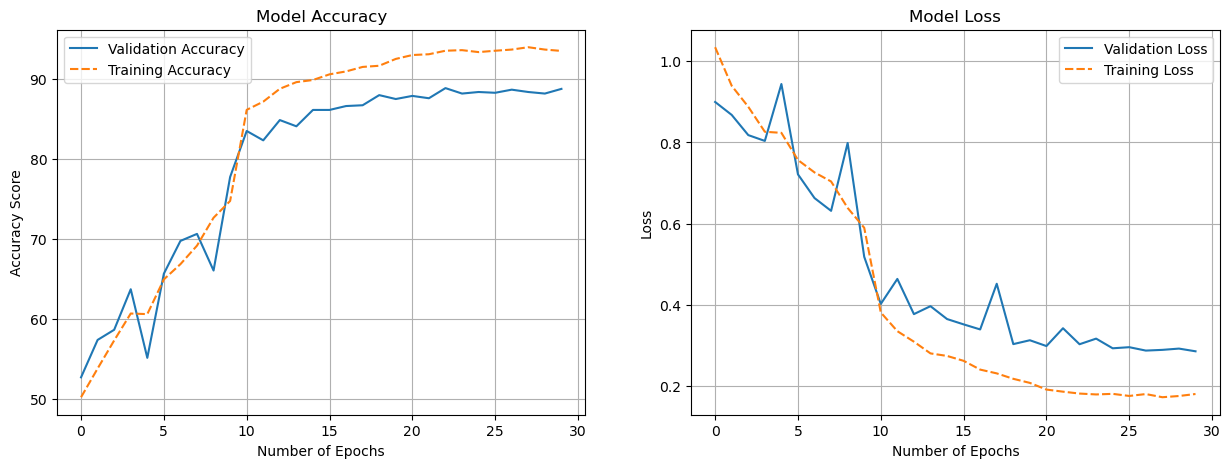

Test Accuracy: 59.89%


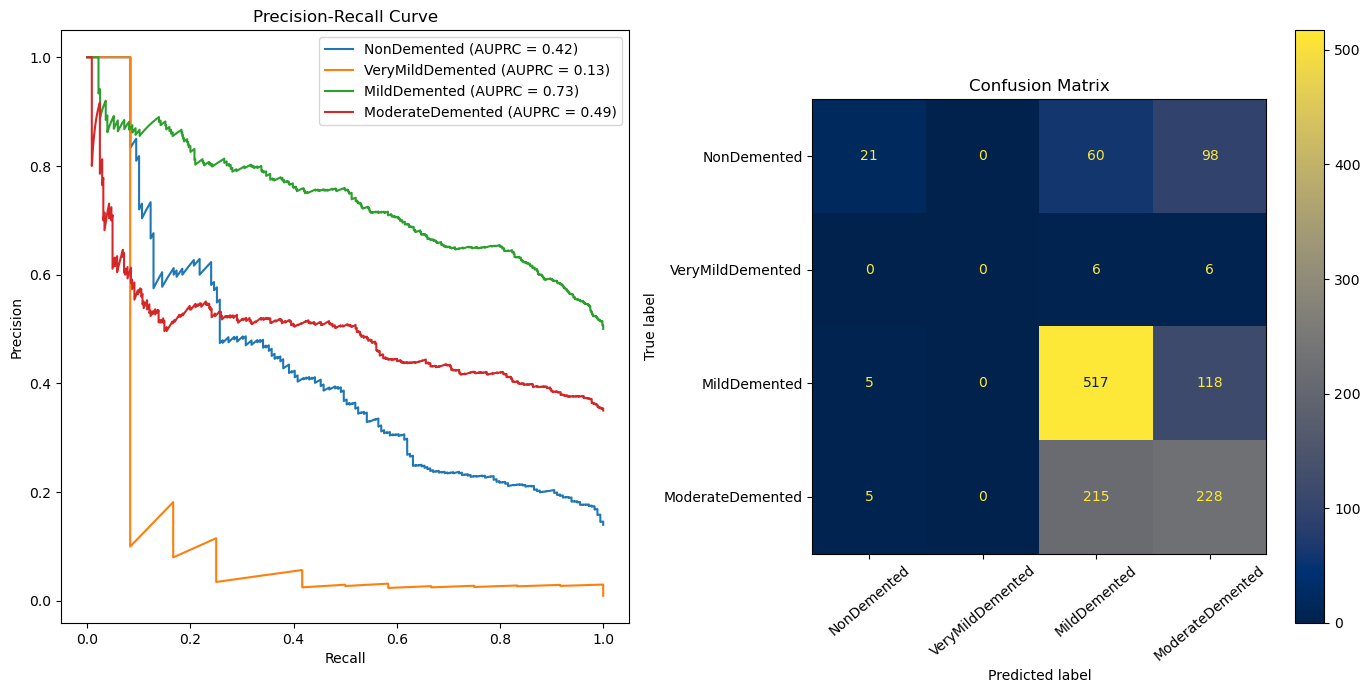

NonDemented: {'Accuracy': 0.869, 'Precision': 0.677, 'Recall': 0.117, 'AUPRC': 0.423}
VeryMildDemented: {'Accuracy': 0.991, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.127}
MildDemented: {'Accuracy': 0.684, 'Precision': 0.648, 'Recall': 0.808, 'AUPRC': 0.734}
ModerateDemented: {'Accuracy': 0.654, 'Precision': 0.507, 'Recall': 0.509, 'AUPRC': 0.49}


In [24]:
# Initialize improved simple neural network
lr = 0.0001
train_loader, val_loader, test_loader = batch_loader(32)  # Use a batch size of 32
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4) # Use adam optimizer and weight decay
model_path = f'{file_dir}\\{net.__class__.__name__}_best_model.pth'

# Train and test model
train(net, train_loader, val_loader, optimizer, epochs=30, lr=lr)
test(net, test_loader, torch.device('cpu'), class_names, model_path)

### Improved Convolutional Network

In [25]:
# Define improved convolutional neural network class
class Conv_NN2(nn.Module):
    """
    Improved convolutional neural network model with multiple convolutional layers and fully connected layers.

    Args:
    - n_channels (int): Number of input channels.

    Attributes:
    - conv1 (nn.Conv2d): First convolutional layer.
    - conv2 (nn.Conv2d): Second convolutional layer.
    - conv3 (nn.Conv2d): Third convolutional layer.
    - conv4 (nn.Conv2d): Fourth convolutional layer.
    - conv5 (nn.Conv2d): Fifth convolutional layer.
    - bn1 (nn.BatchNorm2d): Batch normalization layer for conv1.
    - bn2 (nn.BatchNorm2d): Batch normalization layer for conv2.
    - bn3 (nn.BatchNorm2d): Batch normalization layer for conv3.
    - bn4 (nn.BatchNorm2d): Batch normalization layer for conv4.
    - bn5 (nn.BatchNorm2d): Batch normalization layer for conv5.
    - pool (nn.MaxPool2d): Max pooling layer.
    - dropout (nn.Dropout): Dropout layer.
    - fc1 (nn.Linear): First fully connected layer.
    - fc2 (nn.Linear): Second fully connected layer.
    - fc3 (nn.Linear): Third fully connected layer.
    - fc4 (nn.Linear): Fourth fully connected layer.
    - fc5 (nn.Linear): Fifth fully connected layer.

    Methods:
    - forward(x): Forward pass through the network.

    """
    def __init__(self, n_channels):
        """
        Initializes the Conv_NN2 model.

        Args:
        - n_channels (int): Number of input channels.
        """
        super().__init__()
        
        # Define convolutional layers & max pooling layer
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        #nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #nn.init.kaiming_uniform_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        #nn.init.kaiming_uniform_(self.conv4.weight)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        #nn.init.kaiming_uniform_(self.conv5.weight)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d((2,2), stride=2)
        
        self.dropout = nn.Dropout(0.3) 
        self.fc1 = None  # will be defined in forward pass
        self.fc2 = nn.Linear(1024, 512) 
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(512, 256)   
        nn.init.xavier_uniform_(self.fc3.weight)
        self.fc4 = nn.Linear(256, 128) 
        #nn.init.xavier_uniform_(self.fc4.weight)
        self.fc5 = nn.Linear(128, 4)
        #nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after passing through the network.
        """
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)  # flatten data
        if self.fc1 is None:  # set fc1 at runtime
            self.fc1 = nn.Linear(x.size(1), 1024).to(x.device)
            nn.init.xavier_uniform_(self.fc1.weight)
            
        x = F.relu(self.fc1(x))             
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))  
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)  
        x = F.log_softmax(self.fc5(x), dim=1)

        return x

In [26]:
# Create an instance of the Conv_NN2 class
torch.manual_seed(3210)
net = Conv_NN2(n_channels=3)

running on cuda...


Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 43.43it/s]


Training Loss: 0.9493 | Training Accuracy: 55.54% | Validation Loss: 0.9336 | Validation Accuracy: 54.34%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.00it/s]


Training Loss: 0.7723 | Training Accuracy: 65.38% | Validation Loss: 0.6594 | Validation Accuracy: 74.24%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.99it/s]


Training Loss: 0.5627 | Training Accuracy: 77.86% | Validation Loss: 0.4576 | Validation Accuracy: 84.29%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.83it/s]


Training Loss: 0.3172 | Training Accuracy: 89.50% | Validation Loss: 0.3032 | Validation Accuracy: 88.98%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.72it/s]


Training Loss: 0.1911 | Training Accuracy: 94.04% | Validation Loss: 0.3104 | Validation Accuracy: 89.66%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.95it/s]


Training Loss: 0.1136 | Training Accuracy: 96.12% | Validation Loss: 0.3769 | Validation Accuracy: 84.39%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.84it/s]


Training Loss: 0.0790 | Training Accuracy: 97.24% | Validation Loss: 0.2258 | Validation Accuracy: 92.68%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.93it/s]


Training Loss: 0.0559 | Training Accuracy: 98.00% | Validation Loss: 0.1561 | Validation Accuracy: 95.22%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.04it/s]


Training Loss: 0.0369 | Training Accuracy: 98.49% | Validation Loss: 0.1556 | Validation Accuracy: 94.63%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.85it/s]


Training Loss: 0.0434 | Training Accuracy: 98.51% | Validation Loss: 0.0692 | Validation Accuracy: 97.17%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.25it/s]


Training Loss: 0.0097 | Training Accuracy: 99.71% | Validation Loss: 0.0695 | Validation Accuracy: 97.85%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.21it/s]


Training Loss: 0.0068 | Training Accuracy: 99.78% | Validation Loss: 0.0669 | Validation Accuracy: 97.95%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.11it/s]


Training Loss: 0.0034 | Training Accuracy: 99.93% | Validation Loss: 0.0529 | Validation Accuracy: 98.24%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.98it/s]


Training Loss: 0.0029 | Training Accuracy: 99.85% | Validation Loss: 0.0488 | Validation Accuracy: 98.34%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.32it/s]


Training Loss: 0.0017 | Training Accuracy: 100.00% | Validation Loss: 0.0630 | Validation Accuracy: 97.66%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.25it/s]


Training Loss: 0.0016 | Training Accuracy: 100.00% | Validation Loss: 0.0447 | Validation Accuracy: 98.54%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.64it/s]


Training Loss: 0.0028 | Training Accuracy: 99.93% | Validation Loss: 0.0439 | Validation Accuracy: 98.54%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.93it/s]


Training Loss: 0.0013 | Training Accuracy: 99.98% | Validation Loss: 0.0623 | Validation Accuracy: 97.95%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.08it/s]


Training Loss: 0.0014 | Training Accuracy: 99.98% | Validation Loss: 0.0415 | Validation Accuracy: 98.63%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.47it/s]


Training Loss: 0.0010 | Training Accuracy: 100.00% | Validation Loss: 0.0515 | Validation Accuracy: 98.24%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.41it/s]


Training Loss: 0.0015 | Training Accuracy: 99.98% | Validation Loss: 0.0501 | Validation Accuracy: 98.24%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.41it/s]


Training Loss: 0.0009 | Training Accuracy: 99.98% | Validation Loss: 0.0495 | Validation Accuracy: 98.34%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.44it/s]


Training Loss: 0.0015 | Training Accuracy: 99.93% | Validation Loss: 0.0472 | Validation Accuracy: 98.34%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.61it/s]


Training Loss: 0.0011 | Training Accuracy: 99.98% | Validation Loss: 0.0488 | Validation Accuracy: 98.34%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.97it/s]


Training Loss: 0.0006 | Training Accuracy: 100.00% | Validation Loss: 0.0474 | Validation Accuracy: 98.34%
Early stopping...


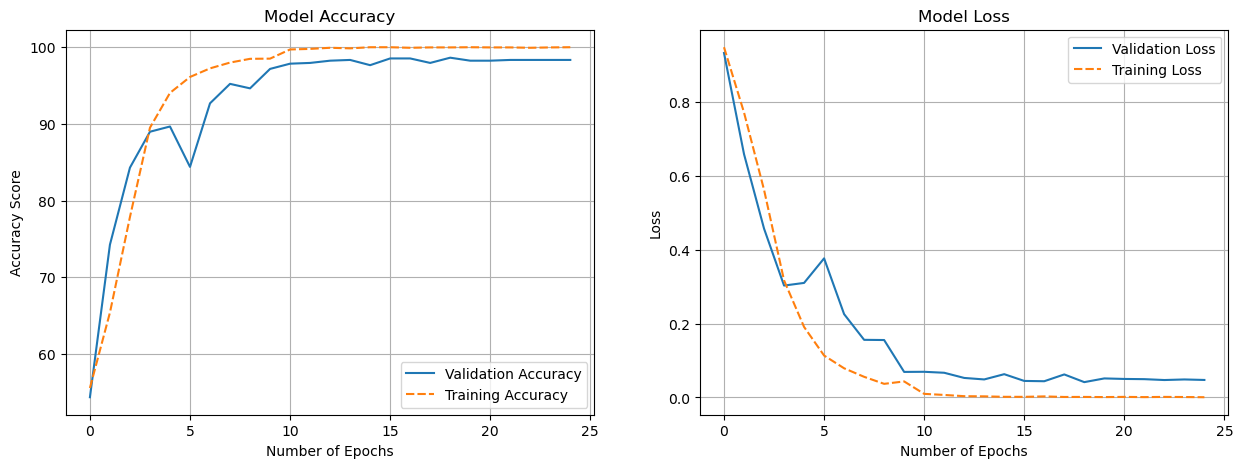

Test Accuracy: 73.03%


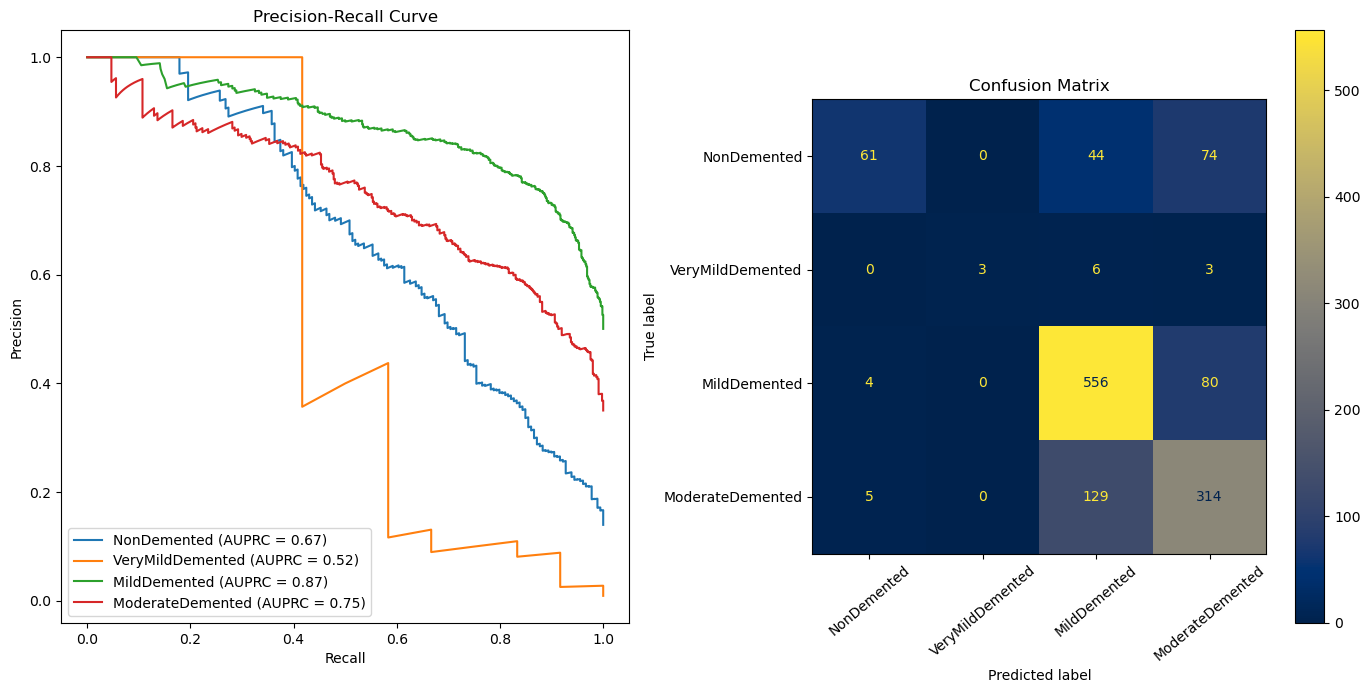

NonDemented: {'Accuracy': 0.901, 'Precision': 0.871, 'Recall': 0.341, 'AUPRC': 0.672}
VeryMildDemented: {'Accuracy': 0.993, 'Precision': 1.0, 'Recall': 0.25, 'AUPRC': 0.519}
MildDemented: {'Accuracy': 0.794, 'Precision': 0.756, 'Recall': 0.869, 'AUPRC': 0.871}
ModerateDemented: {'Accuracy': 0.772, 'Precision': 0.667, 'Recall': 0.701, 'AUPRC': 0.749}


In [27]:
# Initialize improved CNN
lr = 0.0001
train_loader, val_loader, test_loader = batch_loader(25)  # Use a batch size of 25
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4) # Use adam optimizer and weight decay
model_path = f'{file_dir}\\{net.__class__.__name__}_best_model.pth'

# Train and test model
train(net, train_loader, val_loader, optimizer, epochs=50, lr=lr)
test(net, test_loader, torch.device('cpu'), class_names, model_path)

### Model Changes & Comparative Analysis

`NETWORK ARCHITECTURE`

**Simple Neural Network**:

The basic model utilizes only fully connected layers and consists of two hidden layers with 2000 and 4 neurons respectively, while the improved model increases the number of layers to 6 with 2048, 1024, 512, 256, 128, and 4 neurons respectively. The improved model also introduces dropout layers to prevent overfitting.

**Convolutional Neural Network**:

The basic model contains two convolutional layers followed by max-pooling while the improved model extends the architecture with five convolutional layers followed by batch normalization and max-pooling. The simple model employs two fully connected layers at the end while the improved model uses five fully connected layers at the end with dropout regularization.

`INITIALIZATION & REGULARIZATION`

**Simple Neural Network**:

In the basic model, no specific initialization or regularization technique was used. In the improved model, however, a dropout with a rate of 0.3 was applied after the first and fifth hidden layers to reduce overfitting. 

**Convolutional Neural Network**:

In the basic model, no specific initialization or regularization technique was used, while the improved model employs Xavier initialization for weights of the fully connected layers, and Kaiming initialization for convolutional layers. The improved model also uses batch normalization to stabilize and speed up the training process, and applies dropout regularization after the first fully connected layer to prevent overfitting.


`OPTIMIZER & HYPERPARAMETERS`

**Simple & Convolutional Neural Network**:

The basic models utilizes the SGD optimizer with a learning rate of 0.01 and no weight decay, and was trained for 10 epochs with a batch size of 100. In the improved models, the Adam optimizer was used with a lower learning rate of 0.0001 and a weight decay of 1e-4. The improved simple neural network was trained with a batch size of 32 for 30 epochs and for the improved Convolutional Neural Network, 50 epochs was used with a batch size of 25.

`PERFORMANCE COMPARISON`

**Simple & Convolutional Neural Network**:

The basic Simple Neural Network achieved a test accuracy of approximately 54.57% while the basic Convolutional Neural Network achieved a test accuracy of approximately 54.34%. Conversely, the improved Simple Neural Network achieved a test accuracy of approximately 59.89%, while the improved Convolutional Neural Network achieved a test accuracy of approximately 73.03%.

**Analysis:**

In the improved models, there is a notable increase in the percentage of correctly predicted class labels for the test instances. In terms of the precision-recall curve, a higher AUPRC indicates that the improved model has a better trade-off between precision and recall across different thresholds, meaning it can maintain a high precision while also capturing a large proportion of positive instances (high recall).
Specifically, there are significantly higher precision and recall values for the `MildDemented` and `ModerateDemented` classes, indicating that the improved models, particularly the optimized Convolutional Neural Network, correctly capture most instances. This is supported by the high AUPRC values of 0.871 and 0.749, respectively. However, the `VeryMildDemented` class exhibits high accuracy with very low precision and recall values across all instances of our neural networks. This may be due to the sparse number of `VeryMildDemented` cases in the data, which could limit the models' ability to learn effectively from them. 

Analyzing the confusion matrix, we observe that the improved models achieve a higher true positive rate for the `NonDemented` class compared to the basic models, although in the improved models, the class performance is comparatively weaker to demented classes. Despite this discrepancy, in the context of real-world medical applications, it would be more favorable to have a false prediction for a non-demented case (false positive) than to misclassify an actual demented case (false negative), as this minimizes the risk of overlooking potential cases of dementia.


Generally, both improved models significantly outperform the basic models. They exhibited better generalization and demonstrate the effectiveness of the model architectural changes, initialization techniques, regularization methods, and optimization strategies.
The introduction of convolutional layers and batch normalization in the Convolutional Neural Network contributed to better feature extraction and representation learning. Also, the use of Xavier and Kaiming initialization techniques ensured stable and efficient training by addressing the exploding gradients problem.
Incorporating dropout regularization mitigated overfitting, leading to improved generalization performance, while the use of the Adam optimizer with lower learning rates and weight decay further enhanced convergence and prevented overfitting in the improved models.

<a id='part2'></a>
# Part 2

Next, using our optimized Convolutional Neural Network alongside the SGD optimizer with all other parameters unchanged, we will evaluate the performance of the optimized model using two different learning rates: $0.00000001$ and $10$.

___Learning rate = 0.00000001___

running on cuda...


Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.68it/s]


Training Loss: 1.4002 | Training Accuracy: 14.33% | Validation Loss: 1.3910 | Validation Accuracy: 14.15%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.60it/s]


Training Loss: 1.4006 | Training Accuracy: 14.26% | Validation Loss: 1.3906 | Validation Accuracy: 14.15%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.64it/s]


Training Loss: 1.4002 | Training Accuracy: 14.31% | Validation Loss: 1.3904 | Validation Accuracy: 14.15%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.00it/s]


Training Loss: 1.3996 | Training Accuracy: 14.40% | Validation Loss: 1.3909 | Validation Accuracy: 14.15%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.80it/s]


Training Loss: 1.3993 | Training Accuracy: 14.26% | Validation Loss: 1.3907 | Validation Accuracy: 14.15%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.71it/s]


Training Loss: 1.4008 | Training Accuracy: 14.33% | Validation Loss: 1.3906 | Validation Accuracy: 14.15%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.11it/s]


Training Loss: 1.3996 | Training Accuracy: 14.38% | Validation Loss: 1.3908 | Validation Accuracy: 14.15%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.22it/s]


Training Loss: 1.3984 | Training Accuracy: 14.43% | Validation Loss: 1.3909 | Validation Accuracy: 14.15%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.30it/s]


Training Loss: 1.4005 | Training Accuracy: 14.65% | Validation Loss: 1.3906 | Validation Accuracy: 14.15%
Early stopping...


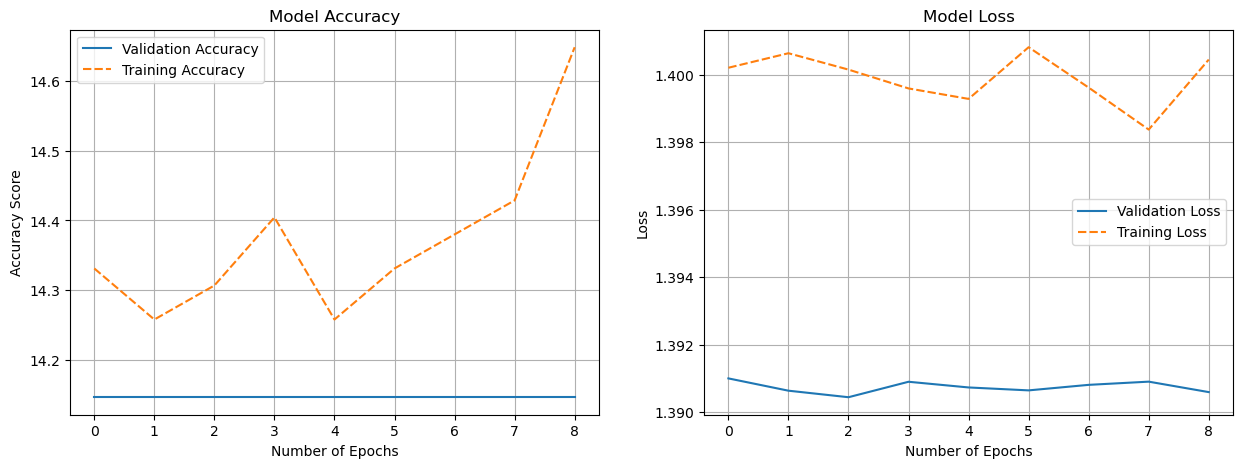

Test Accuracy: 14.00%


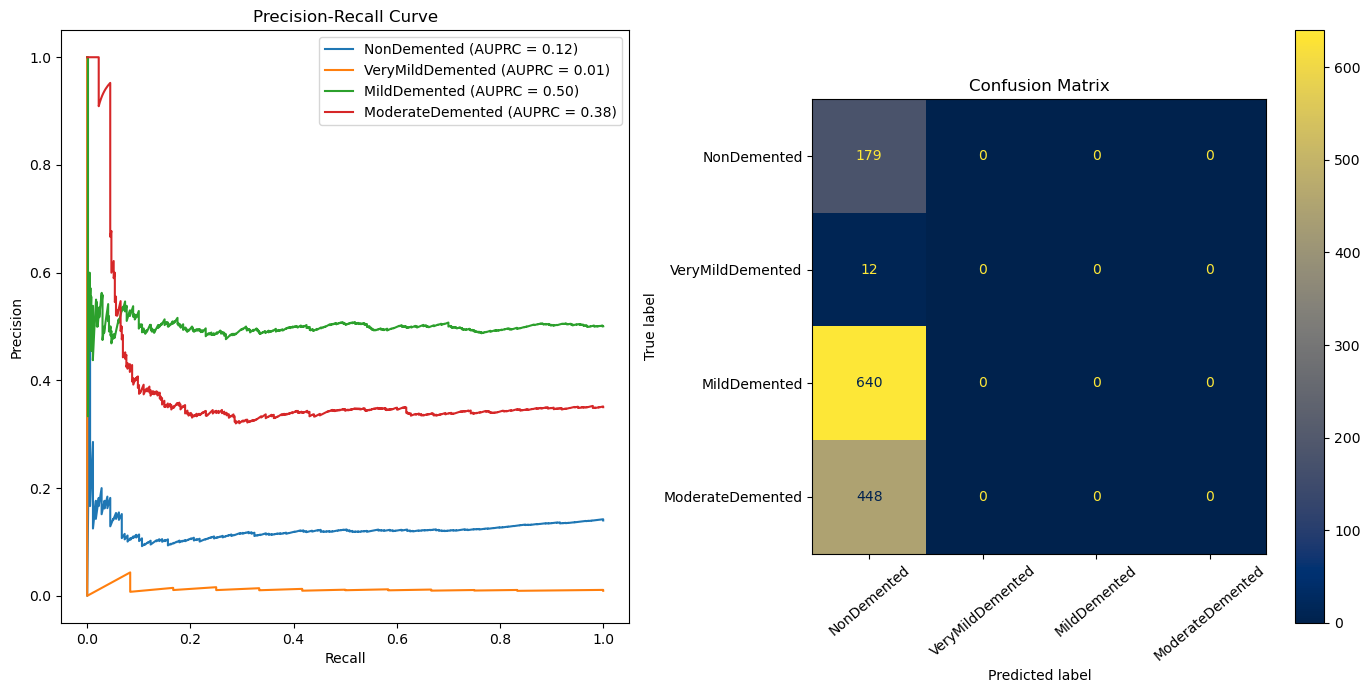

NonDemented: {'Accuracy': 0.14, 'Precision': 0.14, 'Recall': 1.0, 'AUPRC': 0.123}
VeryMildDemented: {'Accuracy': 0.991, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.012}
MildDemented: {'Accuracy': 0.5, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.5}
ModerateDemented: {'Accuracy': 0.65, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.379}


In [28]:
# Create an instance of the Conv_NN2 class and initialize model
torch.manual_seed(3210)
net = Conv_NN2(n_channels=3)

lr = 0.00000001
train_loader, val_loader, test_loader = batch_loader(25)  # Use a batch size of 25
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-4) # Use SGD optimizer
model_path = f'{file_dir}\\{net.__class__.__name__}_best_model.pth'

# Train and test model
train(net, train_loader, val_loader, optimizer, epochs=50, lr=lr)
test(net, test_loader, torch.device('cpu'), class_names, model_path)

___Learning rate = 10___

running on cuda...


Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.02it/s]


Training Loss: 4.3211 | Training Accuracy: 40.48% | Validation Loss: 1.1652 | Validation Accuracy: 50.54%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.26it/s]


Training Loss: 2.2855 | Training Accuracy: 40.21% | Validation Loss: 2.0922 | Validation Accuracy: 14.15%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.67it/s]


Training Loss: 2.3074 | Training Accuracy: 40.26% | Validation Loss: 1.1168 | Validation Accuracy: 34.34%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.64it/s]


Training Loss: 2.2010 | Training Accuracy: 42.02% | Validation Loss: 2.7906 | Validation Accuracy: 50.54%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.37it/s]


Training Loss: 2.3171 | Training Accuracy: 40.77% | Validation Loss: 3.7409 | Validation Accuracy: 14.15%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.09it/s]


Training Loss: 2.2551 | Training Accuracy: 41.09% | Validation Loss: 1.6924 | Validation Accuracy: 50.54%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.09it/s]


Training Loss: 2.1617 | Training Accuracy: 41.41% | Validation Loss: 1.0924 | Validation Accuracy: 50.54%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.77it/s]


Training Loss: 2.2663 | Training Accuracy: 42.04% | Validation Loss: 3.1837 | Validation Accuracy: 50.54%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.91it/s]


Training Loss: 2.3931 | Training Accuracy: 40.14% | Validation Loss: 2.7051 | Validation Accuracy: 34.34%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.61it/s]


Training Loss: 2.1481 | Training Accuracy: 41.85% | Validation Loss: 2.7659 | Validation Accuracy: 50.54%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.93it/s]


Training Loss: 1.0931 | Training Accuracy: 49.00% | Validation Loss: 1.0386 | Validation Accuracy: 50.54%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.99it/s]


Training Loss: 1.0455 | Training Accuracy: 49.22% | Validation Loss: 1.0397 | Validation Accuracy: 50.54%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.76it/s]


Training Loss: 1.0448 | Training Accuracy: 49.00% | Validation Loss: 1.0364 | Validation Accuracy: 50.54%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.97it/s]


Training Loss: 1.0436 | Training Accuracy: 49.27% | Validation Loss: 1.0813 | Validation Accuracy: 34.34%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.05it/s]


Training Loss: 1.0442 | Training Accuracy: 48.36% | Validation Loss: 1.0352 | Validation Accuracy: 50.54%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 46.74it/s]


Training Loss: 1.0442 | Training Accuracy: 49.05% | Validation Loss: 1.0351 | Validation Accuracy: 50.54%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.65it/s]


Training Loss: 1.0429 | Training Accuracy: 48.85% | Validation Loss: 1.0430 | Validation Accuracy: 50.54%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.51it/s]


Training Loss: 1.0431 | Training Accuracy: 48.97% | Validation Loss: 1.0344 | Validation Accuracy: 50.54%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.91it/s]


Training Loss: 1.0419 | Training Accuracy: 49.19% | Validation Loss: 1.0390 | Validation Accuracy: 50.54%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.79it/s]


Training Loss: 1.0454 | Training Accuracy: 49.27% | Validation Loss: 1.0568 | Validation Accuracy: 34.34%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.24it/s]


Training Loss: 1.0383 | Training Accuracy: 49.39% | Validation Loss: 1.0343 | Validation Accuracy: 50.54%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.18it/s]


Training Loss: 1.0369 | Training Accuracy: 49.85% | Validation Loss: 1.0350 | Validation Accuracy: 50.54%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.31it/s]


Training Loss: 1.0373 | Training Accuracy: 49.85% | Validation Loss: 1.0339 | Validation Accuracy: 50.54%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.03it/s]


Training Loss: 1.0369 | Training Accuracy: 49.85% | Validation Loss: 1.0342 | Validation Accuracy: 50.54%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.84it/s]


Training Loss: 1.0372 | Training Accuracy: 49.85% | Validation Loss: 1.0348 | Validation Accuracy: 50.54%


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.89it/s]


Training Loss: 1.0374 | Training Accuracy: 49.85% | Validation Loss: 1.0345 | Validation Accuracy: 50.54%


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 47.78it/s]


Training Loss: 1.0362 | Training Accuracy: 49.85% | Validation Loss: 1.0361 | Validation Accuracy: 50.54%


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 48.48it/s]


Training Loss: 1.0367 | Training Accuracy: 49.85% | Validation Loss: 1.0364 | Validation Accuracy: 50.54%


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 49.30it/s]


Training Loss: 1.0370 | Training Accuracy: 49.85% | Validation Loss: 1.0340 | Validation Accuracy: 50.54%
Early stopping...


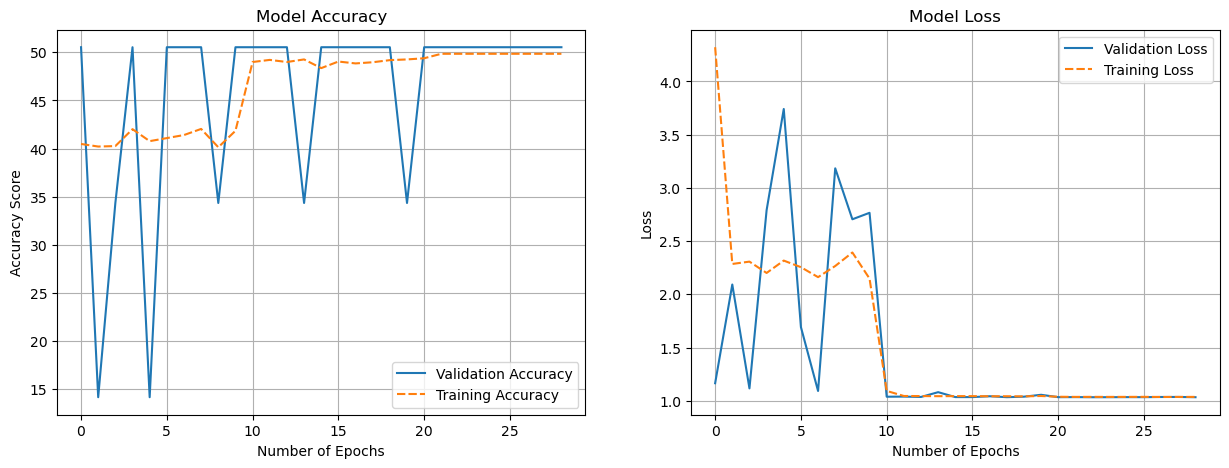

Test Accuracy: 50.04%


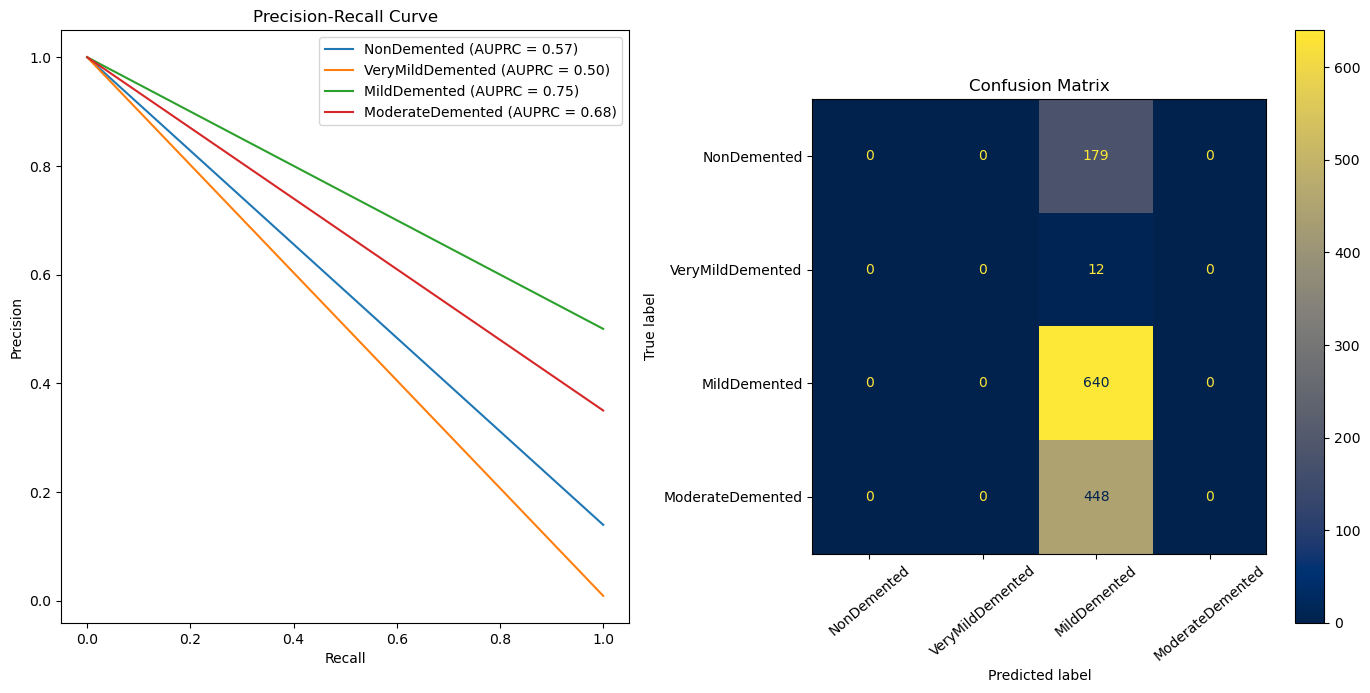

NonDemented: {'Accuracy': 0.86, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.57}
VeryMildDemented: {'Accuracy': 0.991, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.505}
MildDemented: {'Accuracy': 0.5, 'Precision': 0.5, 'Recall': 1.0, 'AUPRC': 0.75}
ModerateDemented: {'Accuracy': 0.65, 'Precision': 0.0, 'Recall': 0.0, 'AUPRC': 0.675}


In [29]:
# Create an instance of the CONV_NN2 class and initialize model
torch.manual_seed(3210)
net = Conv_NN2(n_channels=3)

lr = 10
train_loader, val_loader, test_loader = batch_loader(25)  # Use a batch size of 25
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=1e-4) # Use SGD optimizer
model_path = f'{file_dir}\\{net.__class__.__name__}_best_model.pth'

# Train and test model
train(net, train_loader, val_loader, optimizer, epochs=50, lr=lr)
test(net, test_loader, torch.device('cpu'), class_names, model_path)

#### Note: 
The learning rate scheduler implemented in our training algorithm played a crucial role in stopping the training early for both instances with high and low learning rates. This ultimately prevented the models' performances from deteriorating further.

**High Learning Rate = 10:**

With a high learning rate of 10, the training loss oscillated dramatically with each epoch, indicating that the model was having difficulty converging. This is clearly visible in the model accuracy plot. Despite the high learning rate, the training accuracy remained relatively low and inconsistent. Also, we observe that the validation accuracy remained stagnant at around 50.54% throughout, suggesting that the model was not learning effectively.


In terms of model performance, the test accuracy was approximately 50.04%, and the model had a high true positive rate for `MildDemented` but struggled with precision. This indicates that the model may be predicting too many instances as positive, leading to a high number of false positives and hence a lower precision. This result is attributable to the high learning rate causing the model to overshoot the optimal solution during training, leading to suboptimal performance.

<u>Advantages</u>

- A higher learning rate can lead to faster convergence, especially in the initial stages of training.
- It can also help escape local minima by allowing the model to take larger steps in the weight space.
    
<u>Disadvantages</u>
    
- There is a risk of divergence if the learning rate is too high as the optimizer may overshoot the minimum, and fail to converge.
- High learning rates can also cause the loss function to oscillate, hindering convergence.
- Also, models with high learning rates may be sensitive to small changes in input data or parameter initialization, leading to unstable training dynamics.

**Low Learning Rate = 0.00000001:**


With the low learning rate of 1e-8, the training loss decreased very slowly but steadily, indicating that the model made gradual progress. However, the training accuracy remained extremely low and didn't improve significantly with each epoch.
We also observe that the validation accuracy remained stuck at around 14.15%, suggesting that the model was not learning meaningful patterns from the data.
    

The model performance yielded a test accuracy of approximately 14%, which is worse than random guessing. The precision-recall curves also suggest poor performance, as they do not show a good trade-off between precision and recall across different thresholds. Similarly, the confusion matrix shows that the model struggles to distinguish between different classes.
    
<u>Advantages</u>
    
- Lower learning rates generally lead to more stable training dynamics and smoother convergence.
- With a lower learning rate, the model may eventually converge to a more precise and accurate result.
    
    
<u>Disadvantages</u>
    
- Using a very low learning rate can result in very slow convergence, requiring more epochs to reach satisfactory results.  
- Also, extremely low learning rates may cause the optimizer to get stuck in a local minimum, hindering progress.

###  Advantages & Disadvantages of Higher & Lower Batch Sizes

`HIGHER BATCH SIZE`

> **Advantages:**

- With larger batch sizes, hardware resources like GPUs can be utilized more efficiently because processing a larger batch of data in parallel can fully leverage the computational power of modern hardware, leading to faster training times.
- Larger batch sizes provide more stable and smooth updates to the model parameters resulting in a smoother descent along the loss landscape during optimization, and faster convergence.
- The noise introduced by mini-batch updates can have a smoothing effect on the model optimization process, helping prevent overfitting by adding a form of implicit regularization.
- With larger batch sizes, the gradients computed for parameter updates are averaged over more data points, reducing the variability in gradient estimates, and leading to more reliable updates.


> **Disadvantages:**

- Larger batch sizes require more memory to store activations, gradients, and intermediate computations during training which can be particularly challenging for models with large parameter sizes or when training on memory-constrained hardware.
- Larger batch sizes could lead to poorer generalization performance such as generalization gap, where the model fails to generalize well to unseen data despite performing well on the training set.
- Large batch sizes can result in stiff optimization dynamics, where the model converges to a suboptimal result due to limited exploration of the parameter space. 
- Larger batch sizes often require tuning of the learning rate and other hyperparameters to maintain stability during training.


`LOWER BATCH SIZE`

> **Advantages:**

- Smaller batch sizes often lead to better generalization performance as the noise introduced by mini-batch updates can act as a form of regularization, preventing the model from overfitting to the training data, and improving its ability to generalize to unseen data.
- Lower batch sizes allow for more exploration of the loss landscape during optimization, which can help the model escape saddle points more effectively, leading to convergence and potentially better results.
- Smaller batch sizes often require less aggressive learning rates, making it easier to tune the learning rate and other hyperparameters, which can simplify the training process and reduce the risk of instability or divergence during optimization.
- Smaller batch sizes consume less memory during training, making them more suitable for models with large parameter sizes or when training on memory-constrained hardware.

> **Disadvantages:**

- Smaller batch sizes may not fully utilize the computational power of modern GPUs, leading to slower training times compared to larger batch sizes.
- With smaller batch sizes, the gradients computed for parameter updates are noisier due to the limited number of data points, which could lead to slower convergence, especially in the presence of noisy or sparse data.
- Training with smaller batch sizes can result in higher variability in the training process, which can make the training less stable and more sensitive to factors like data shuffling, choice of initialization, and choice of optimization algorithm.
- While smaller batch sizes can improve generalization performance, they may also increase the risk of overfitting, especially when training on small datasets or with complex models.